## 1. Environment Setup and Data Loading

We begin by importing necessary libraries and loading the dataset from Hugging Face.

In [1]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Text processing
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from collections import Counter

# Dataset loading
from datasets import load_dataset

# Configuration
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the medical transcriptions dataset from Hugging Face
# This dataset contains 2,460 anonymized medical case transcriptions
print("Loading dataset from Hugging Face...")
dataset = load_dataset('hpe-ai/medical-cases-classification-tutorial')

# Convert to pandas DataFrames for easier manipulation
train_df = pd.DataFrame(dataset['train'])
val_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

print(f"\nDataset loaded successfully!")
print(f"Training set: {len(train_df)} records")
print(f"Validation set: {len(val_df)} records")
print(f"Test set: {len(test_df)} records")
print(f"Total: {len(train_df) + len(val_df) + len(test_df)} records")

Loading dataset from Hugging Face...


Repo card metadata block was not found. Setting CardData to empty.



Dataset loaded successfully!
Training set: 1724 records
Validation set: 370 records
Test set: 370 records
Total: 2464 records


## 2. Initial Data Exploration

Understanding the structure and basic characteristics of our dataset.

In [3]:
# Display basic information about the training dataset
print("Dataset Shape:", train_df.shape)
print("\nColumn Names and Types:")
print(train_df.dtypes)
print("\nFirst few rows:")
train_df.head()

Dataset Shape: (1724, 5)

Column Names and Types:
description          object
transcription        object
sample_name          object
medical_specialty    object
keywords             object
dtype: object

First few rows:


,description,transcription,sample_name,medical_specialty,keywords
0,Pacemaker ICD interrogation. Severe nonischem...,"PROCEDURE NOTE: , Pacemaker ICD interrogation....",Pacemaker Interrogation,Cardiovascular / Pulmonary,"cardiovascular / pulmonary, cardiomyopathy, ve..."
1,"Erythema of the right knee and leg, possible s...","PREOPERATIVE DIAGNOSES: , Erythema of the righ...",Aspiration - Knee Joint,Orthopedic,"orthopedic, knee and leg, anterolateral portal..."
2,Left cardiac catheterization with selective ri...,"PREOPERATIVE DIAGNOSIS: , Post infarct angina....",Cardiac Cath & Selective Coronary Angiography,Cardiovascular / Pulmonary,"cardiovascular / pulmonary, selective, angiogr..."
3,Patient with a history of coronary artery dise...,"REASON FOR VISIT: , Acute kidney failure.,HIST...",Acute Kidney Failure,Nephrology,None
4,Cardiac evaluation and treatment in a patient ...,"REASON FOR REFERRAL: , Cardiac evaluation and ...",Cardiac Consultation - 6,Cardiovascular / Pulmonary,None


In [4]:
# Check for missing values across all columns
print("Missing Values Analysis:")
print("\nTraining Set:")
print(train_df.isnull().sum())
print(f"\nPercentage of missing values:")
print((train_df.isnull().sum() / len(train_df) * 100).round(2))

Missing Values Analysis:

Training Set:
description            0
transcription          0
sample_name            0
medical_specialty      0
keywords             615
dtype: int64

Percentage of missing values:
description           0.00
transcription         0.00
sample_name           0.00
medical_specialty     0.00
keywords             35.67
dtype: float64


In [5]:
# Examine a sample transcription to understand the text structure
print("Sample Medical Transcription:")
print("="*80)
print(f"Medical Specialty: {train_df.iloc[0]['medical_specialty']}")
print(f"\nDescription: {train_df.iloc[0]['description'][:200]}...")
print(f"\nTranscription (first 500 chars): {train_df.iloc[0]['transcription'][:500]}...")
print(f"\nKeywords: {train_df.iloc[0]['keywords']}")

Sample Medical Transcription:
Medical Specialty: Cardiovascular / Pulmonary

Description: Pacemaker ICD interrogation.  Severe nonischemic cardiomyopathy with prior ventricular tachycardia....

Transcription (first 500 chars): PROCEDURE NOTE: , Pacemaker ICD interrogation.,HISTORY OF PRESENT ILLNESS: , The patient is a 67-year-old gentleman who was admitted to the hospital.  He has had ICD pacemaker implantation.  This is a St. Jude Medical model current DRRS, 12345 pacemaker.,DIAGNOSIS: , Severe nonischemic cardiomyopathy with prior ventricular tachycardia.,FINDINGS: , The patient is a DDD mode base rate of 60, max tracking rate of 110 beats per minute, atrial lead is set at 2.5 volts with a pulse width of 0.5 msec, ...

Keywords: cardiovascular / pulmonary, cardiomyopathy, ventricular, tachycardia, pacemaker icd interrogation, millivolts, impendence, interrogation, pacemaker,


## 3. Target Variable Analysis

Analyzing the distribution of medical specialties to identify potential class imbalance.

In [6]:
# Count the distribution of medical specialties
specialty_counts = train_df['medical_specialty'].value_counts()
print("Medical Specialty Distribution:")
print(specialty_counts)
print(f"\nNumber of unique specialties: {train_df['medical_specialty'].nunique()}")

Medical Specialty Distribution:
medical_specialty
Cardiovascular / Pulmonary    526
Orthopedic                    289
Neurology                     187
Gastroenterology              152
Obstetrics / Gynecology       126
Hematology - Oncology          86
Neurosurgery                   76
ENT - Otolaryngology           53
Pediatrics - Neonatal          51
Psychiatry / Psychology        49
Nephrology                     45
Ophthalmology                  45
Radiology                      39
Name: count, dtype: int64

Number of unique specialties: 13


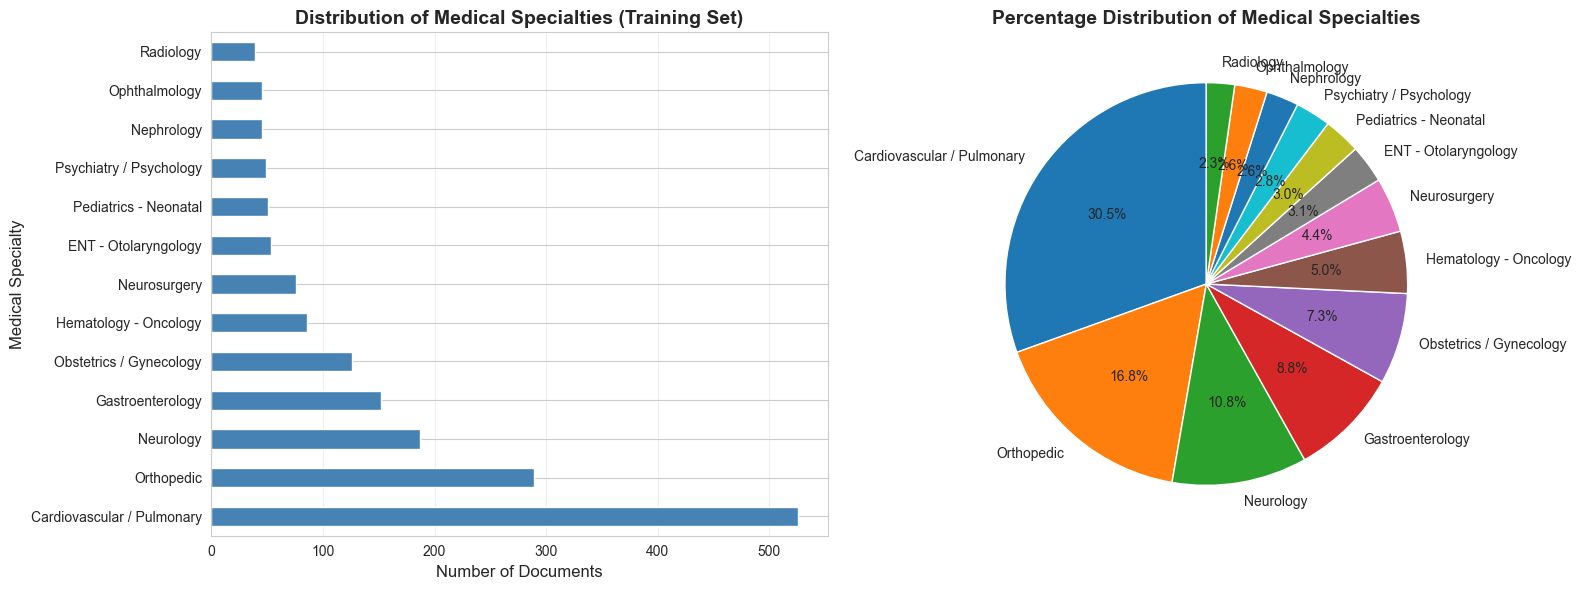


Class Imbalance Ratio: 13.49:1
Most common specialty: Cardiovascular / Pulmonary (526 documents)
Least common specialty: Radiology (39 documents)


In [7]:
# Visualize the class distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
specialty_counts.plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_xlabel('Number of Documents', fontsize=12)
axes[0].set_ylabel('Medical Specialty', fontsize=12)
axes[0].set_title('Distribution of Medical Specialties (Training Set)', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Pie chart for percentage distribution
axes[1].pie(specialty_counts.values, labels=specialty_counts.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Percentage Distribution of Medical Specialties', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate imbalance ratio
max_class = specialty_counts.max()
min_class = specialty_counts.min()
imbalance_ratio = max_class / min_class
print(f"\nClass Imbalance Ratio: {imbalance_ratio:.2f}:1")
print(f"Most common specialty: {specialty_counts.index[0]} ({specialty_counts.values[0]} documents)")
print(f"Least common specialty: {specialty_counts.index[-1]} ({specialty_counts.values[-1]} documents)")

## 4. Text-Based Analysis

Analyzing the characteristics of the text data, including document length and word distributions.

In [8]:
# Calculate document lengths for both transcription and description fields
train_df['transcription_length'] = train_df['transcription'].apply(lambda x: len(str(x).split()))
train_df['description_length'] = train_df['description'].apply(lambda x: len(str(x).split()))

print("Document Length Statistics:")
print("\nTranscription Length:")
print(train_df['transcription_length'].describe())
print("\nDescription Length:")
print(train_df['description_length'].describe())

Document Length Statistics:

Transcription Length:
count    1724.000000
mean      503.957657
std       336.002838
min         1.000000
25%       255.000000
50%       427.000000
75%       689.250000
max      2460.000000
Name: transcription_length, dtype: float64

Description Length:
count    1724.000000
mean       19.655452
std        12.547237
min         2.000000
25%         9.750000
50%        16.000000
75%        27.000000
max        76.000000
Name: description_length, dtype: float64


medical_specialty
Gastroenterology              392.157895
Ophthalmology                 427.044444
Cardiovascular / Pulmonary    434.623574
Radiology                     437.153846
Hematology - Oncology         461.313953
Nephrology                    474.733333
Obstetrics / Gynecology       489.476190
ENT - Otolaryngology          501.056604
Neurology                     549.647059
Pediatrics - Neonatal         579.980392
Orthopedic                    605.411765
Neurosurgery                  617.276316
Psychiatry / Psychology       833.285714
Name: transcription_length, dtype: float64


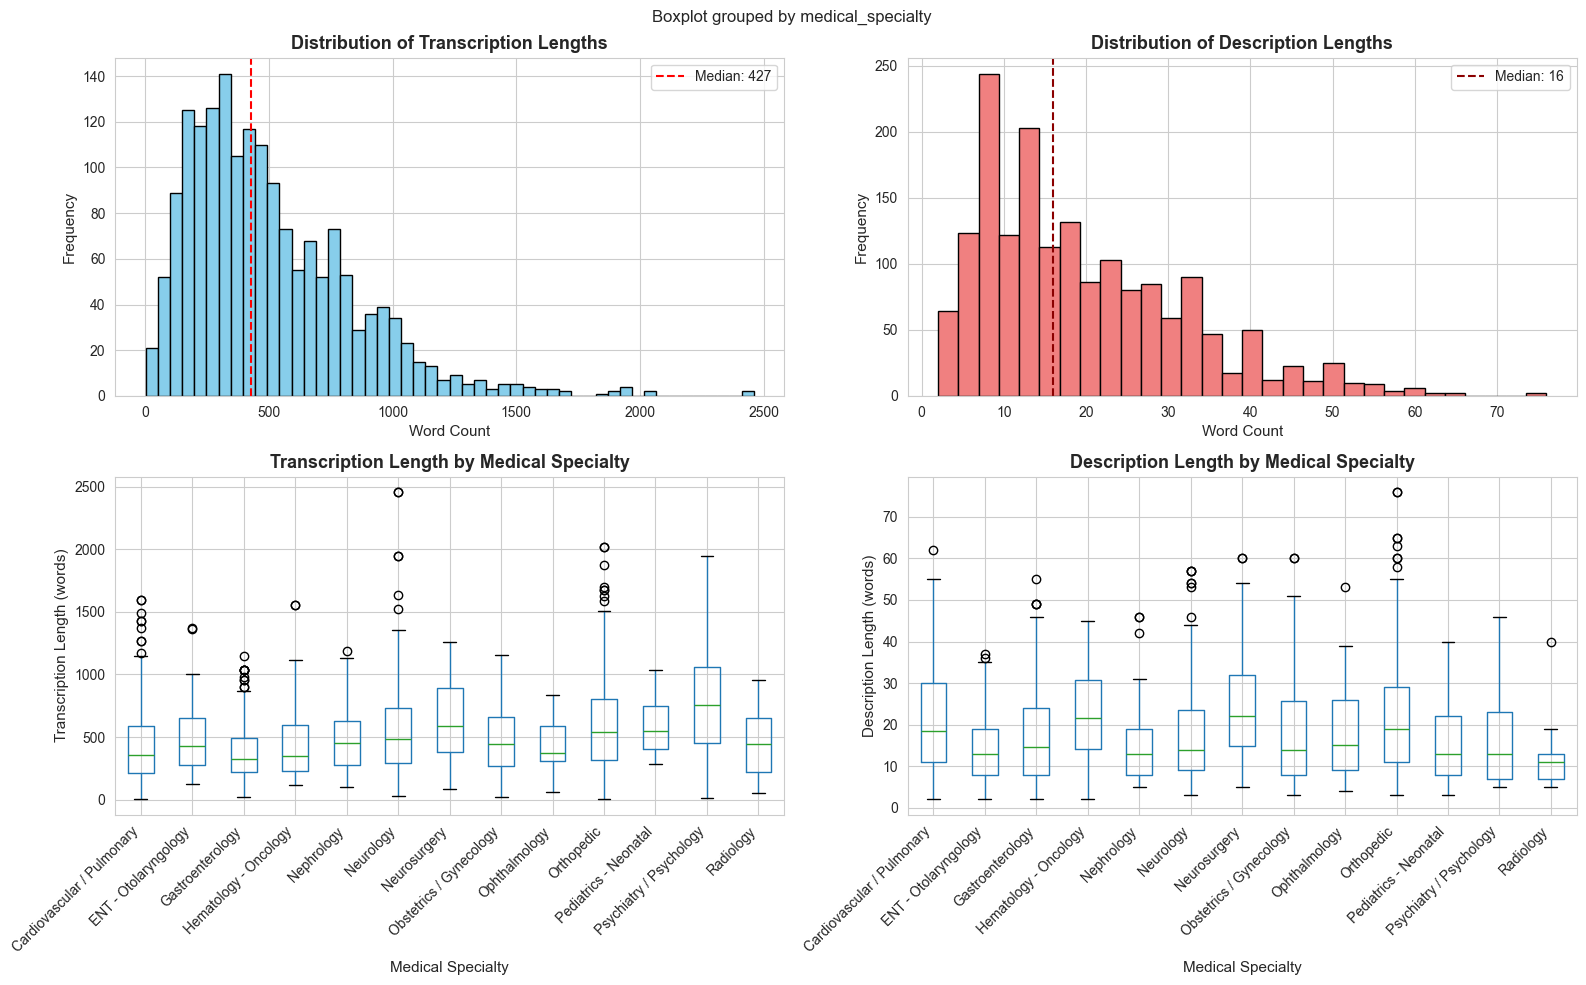

In [9]:
# Visualize document length distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Transcription length histogram
axes[0, 0].hist(train_df['transcription_length'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Word Count', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Distribution of Transcription Lengths', fontsize=13, fontweight='bold')
axes[0, 0].axvline(train_df['transcription_length'].median(), color='red', linestyle='--', label=f"Median: {train_df['transcription_length'].median():.0f}")
axes[0, 0].legend()

# Description length histogram
axes[0, 1].hist(train_df['description_length'], bins=30, color='lightcoral', edgecolor='black')
axes[0, 1].set_xlabel('Word Count', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Distribution of Description Lengths', fontsize=13, fontweight='bold')
axes[0, 1].axvline(train_df['description_length'].median(), color='darkred', linestyle='--', label=f"Median: {train_df['description_length'].median():.0f}")
axes[0, 1].legend()

# Box plot for transcription length by specialty
train_df.boxplot(column='transcription_length', by='medical_specialty', ax=axes[1, 0], rot=90)
axes[1, 0].set_xlabel('Medical Specialty', fontsize=11)
axes[1, 0].set_ylabel('Transcription Length (words)', fontsize=11)
axes[1, 0].set_title('Transcription Length by Medical Specialty', fontsize=13, fontweight='bold')
plt.sca(axes[1, 0])
plt.xticks(rotation=45, ha='right')

# Box plot for description length by specialty
train_df.boxplot(column='description_length', by='medical_specialty', ax=axes[1, 1], rot=90)
axes[1, 1].set_xlabel('Medical Specialty', fontsize=11)
axes[1, 1].set_ylabel('Description Length (words)', fontsize=11)
axes[1, 1].set_title('Description Length by Medical Specialty', fontsize=13, fontweight='bold')
plt.sca(axes[1, 1])
plt.xticks(rotation=45, ha='right')

avg_lengths = train_df.groupby("medical_specialty")["transcription_length"].mean().sort_values()
print(avg_lengths)

plt.tight_layout()
plt.show()

## 5. Word Frequency Analysis

Examining the most common words across all documents and within specific specialties.

In [10]:
# Function to extract and count words from text
def get_word_frequencies(text_series, top_n=20):
    """
    Extract word frequencies from a series of text documents.
    Performs basic text cleaning and tokenization.
    """
    all_words = []
    for text in text_series:
        # Convert to lowercase and extract words
        words = re.findall(r'\b[a-z]+\b', str(text).lower())
        all_words.extend(words)
    
    # Count word frequencies
    word_freq = Counter(all_words)
    
    # Remove common stop words manually for this analysis
    common_stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 
                         'of', 'with', 'is', 'was', 'were', 'been', 'be', 'have', 'has', 'had',
                         'this', 'that', 'these', 'those', 'her', 'his', 'she', 'he', 'it'}
    
    filtered_freq = {word: count for word, count in word_freq.items() 
                     if word not in common_stop_words and len(word) > 2}
    
    return dict(Counter(filtered_freq).most_common(top_n))

# Get overall word frequencies
overall_word_freq = get_word_frequencies(train_df['transcription'], top_n=30)

print("Top 30 Most Common Words (after removing stop words):")
for word, count in list(overall_word_freq.items())[:30]:
    print(f"{word}: {count}")

Top 30 Most Common Words (after removing stop words):
patient: 8263
right: 4879
left: 4607
then: 4353
there: 3753
history: 3691
normal: 2842
not: 2595
procedure: 2550
placed: 2500
from: 2422
well: 2315
which: 2111
are: 2086
pain: 2015
artery: 1830
any: 1717
after: 1648
also: 1587
noted: 1553
performed: 1549
time: 1545
using: 1497
into: 1466
will: 1430
anterior: 1360
removed: 1351
blood: 1347
used: 1340
all: 1332


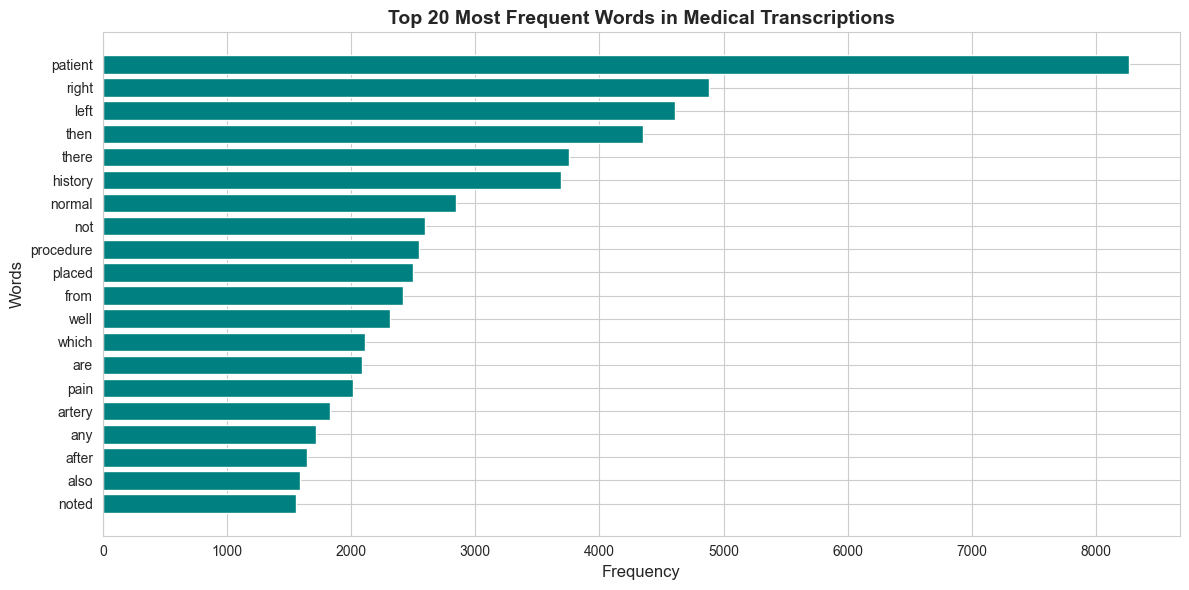

In [11]:
# Visualize top words
fig, ax = plt.subplots(figsize=(12, 6))
words = list(overall_word_freq.keys())[:20]
counts = list(overall_word_freq.values())[:20]

ax.barh(words, counts, color='teal')
ax.set_xlabel('Frequency', fontsize=12)
ax.set_ylabel('Words', fontsize=12)
ax.set_title('Top 20 Most Frequent Words in Medical Transcriptions', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 6. Word Clouds by Medical Specialty

Generating word clouds to visualize the most prominent terms in different medical specialties.

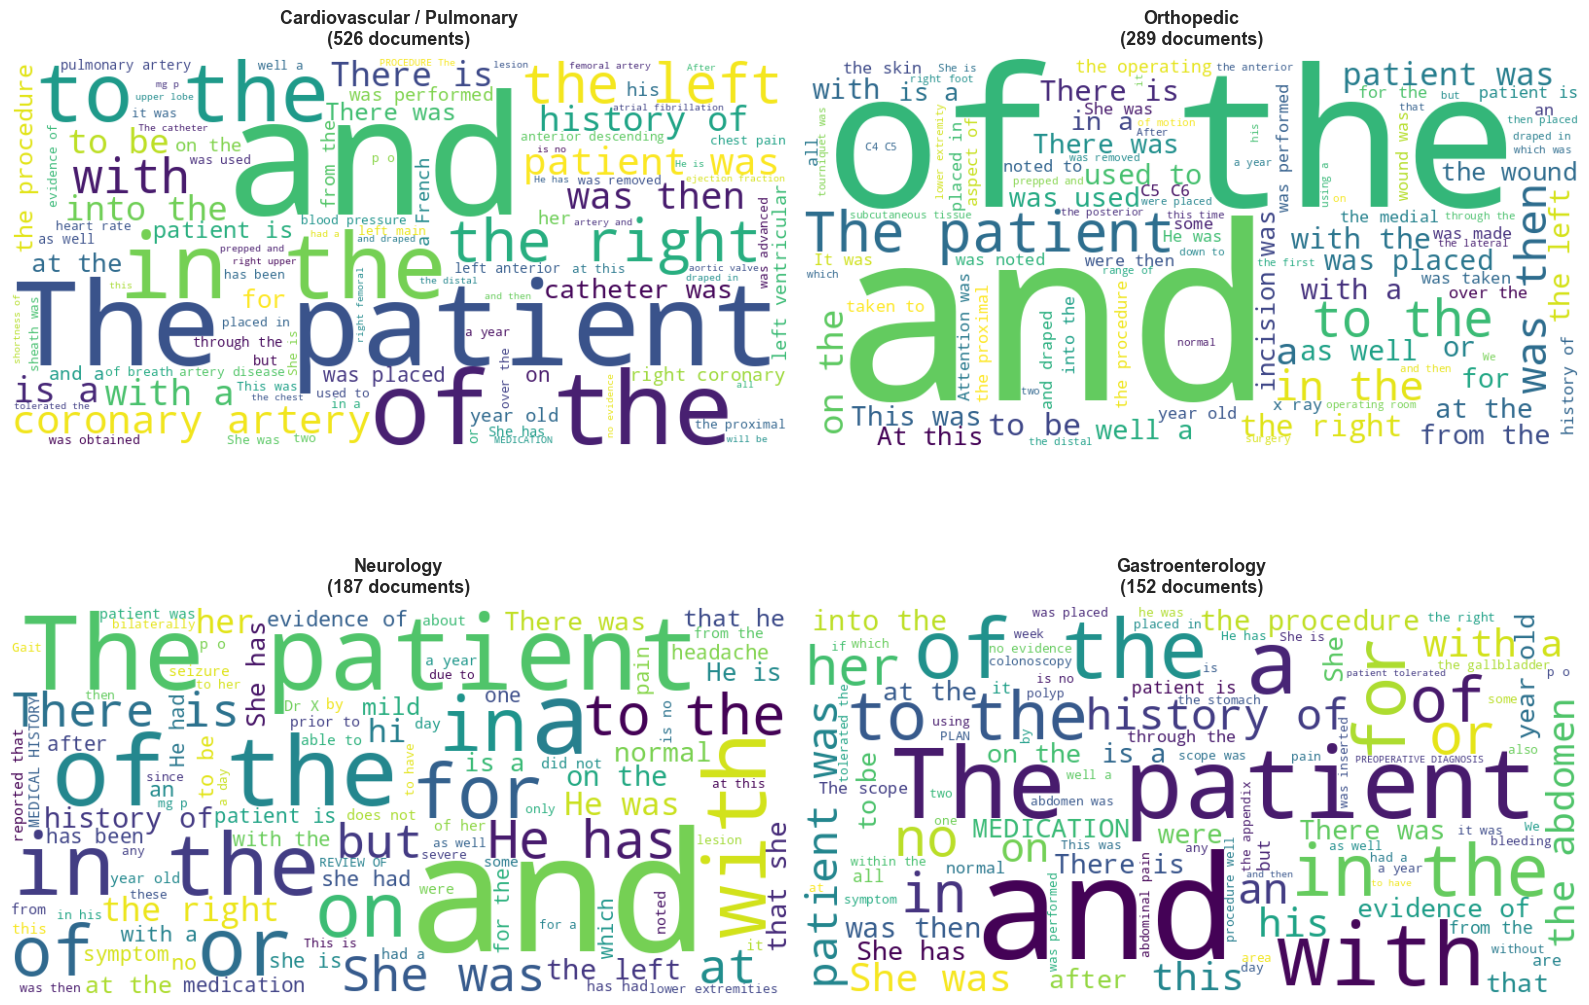


Word clouds generated for top 4 specialties.
These visualizations help identify specialty-specific terminology and key medical concepts.


In [12]:
# Select top 4 specialties for word cloud visualization
top_specialties = train_df['medical_specialty'].value_counts().head(4).index.tolist()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, specialty in enumerate(top_specialties):
    # Filter documents for this specialty
    specialty_text = ' '.join(train_df[train_df['medical_specialty'] == specialty]['transcription'].astype(str))
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, 
                         background_color='white',
                         stopwords='english',
                         colormap='viridis',
                         max_words=100).generate(specialty_text)
    
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].axis('off')
    axes[idx].set_title(f'{specialty}\n({len(train_df[train_df["medical_specialty"] == specialty])} documents)', 
                       fontsize=13, fontweight='bold', pad=10)

plt.tight_layout()
plt.show()

print("\nWord clouds generated for top 4 specialties.")
print("These visualizations help identify specialty-specific terminology and key medical concepts.")

## 7. Specialty-Specific Word Analysis

Identifying distinctive words for each medical specialty that could be strong predictive features.

In [13]:
# Analyze word frequencies for top specialties
print("Top 10 Words by Medical Specialty:\n")
print("="*80)

for specialty in top_specialties:
    specialty_docs = train_df[train_df['medical_specialty'] == specialty]['transcription']
    specialty_words = get_word_frequencies(specialty_docs, top_n=10)
    
    print(f"\n{specialty}:")
    print("-" * 40)
    for word, count in specialty_words.items():
        print(f"  {word}: {count}")

Top 10 Words by Medical Specialty:


Cardiovascular / Pulmonary:
----------------------------------------
  patient: 2388
  left: 2139
  right: 1915
  artery: 1549
  then: 1056
  coronary: 1035
  there: 996
  history: 971
  normal: 929
  procedure: 915

Orthopedic:
----------------------------------------
  patient: 1638
  then: 1384
  right: 1097
  there: 835
  left: 791
  placed: 763
  pain: 736
  well: 592
  procedure: 536
  from: 523

Neurology:
----------------------------------------
  patient: 753
  left: 560
  there: 543
  right: 537
  not: 502
  history: 476
  normal: 428
  are: 356
  from: 267
  any: 263

Gastroenterology:
----------------------------------------
  patient: 686
  history: 327
  procedure: 273
  there: 270
  then: 242
  normal: 239
  abdomen: 187
  well: 183
  pain: 183
  are: 173


## 8. TF-IDF Preprocessing Pipeline Development

Creating a robust text preprocessing pipeline using Scikit-learn's TfidfVectorizer. This single tool handles multiple preprocessing steps internally.

In [14]:
# Initialize TfidfVectorizer with carefully chosen parameters

tfidf_vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    max_features=10000,         
    min_df=2,
    max_df=0.85,                 
    ngram_range=(1, 3),          
    strip_accents='unicode',
    token_pattern=r'\b[a-zA-Z]{3,}\b', 
    sublinear_tf=True,           
    use_idf=True,
    smooth_idf=True,
    norm='l2'
)

print("TF-IDF Vectorizer initialized with the following configuration:")
print(f"  - Text cleaning: lowercase={tfidf_vectorizer.lowercase}")
print(f"  - Stop words: {tfidf_vectorizer.stop_words}")
print(f"  - Max features: {tfidf_vectorizer.max_features}")
print(f"  - Min document frequency: {tfidf_vectorizer.min_df}")
print(f"  - Max document frequency: {tfidf_vectorizer.max_df}")
print(f"  - N-gram range: {tfidf_vectorizer.ngram_range}")
print(f"  - Token pattern: {tfidf_vectorizer.token_pattern}")

TF-IDF Vectorizer initialized with the following configuration:
  - Text cleaning: lowercase=True
  - Stop words: english
  - Max features: 10000
  - Min document frequency: 2
  - Max document frequency: 0.85
  - N-gram range: (1, 3)
  - Token pattern: \b[a-zA-Z]{3,}\b


In [15]:
# Fit the vectorizer on training data and transform all datasets
# We use the 'transcription' field as it contains the most detailed information

print("\nFitting TF-IDF vectorizer on training data...")
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['transcription'])

print("Transforming validation and test data...")
X_val_tfidf = tfidf_vectorizer.transform(val_df['transcription'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['transcription'])

# Extract target variables
y_train = train_df['medical_specialty']
y_val = val_df['medical_specialty']
y_test = test_df['medical_specialty']

print("\nVectorization complete!")
print(f"Training set shape: {X_train_tfidf.shape}")
print(f"Validation set shape: {X_val_tfidf.shape}")
print(f"Test set shape: {X_test_tfidf.shape}")
print(f"\nFeature space dimensionality: {X_train_tfidf.shape[1]} features")
print(f"Sparsity: {(1 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])) * 100:.2f}%")


Fitting TF-IDF vectorizer on training data...
Transforming validation and test data...

Vectorization complete!
Training set shape: (1724, 10000)
Validation set shape: (370, 10000)
Test set shape: (370, 10000)

Feature space dimensionality: 10000 features
Sparsity: 97.73%


## 9. Analyzing the TF-IDF Features

Examining the most important features identified by the TF-IDF vectorizer.

In [16]:
# Get feature names (vocabulary)
feature_names = tfidf_vectorizer.get_feature_names_out()

print(f"Total vocabulary size: {len(feature_names)}")
print(f"\nSample features (first 30):")
print(feature_names[:30])

# Calculate mean TF-IDF scores for each feature
mean_tfidf = np.asarray(X_train_tfidf.mean(axis=0)).flatten()
top_features_idx = mean_tfidf.argsort()[-20:][::-1]

print("\n\nTop 20 Features by Mean TF-IDF Score:")
print("="*50)
for idx in top_features_idx:
    print(f"{feature_names[idx]}: {mean_tfidf[idx]:.4f}")

Total vocabulary size: 10000

Sample features (first 30):
['abbreviated' 'abbreviated scale' 'abbreviated scale intelligence' 'abc'
 'abc year' 'abc year old' 'abcd' 'abcd general' 'abcd general hospital'
 'abcd hospital' 'abdomen' 'abdomen abdomen' 'abdomen benign'
 'abdomen bowel' 'abdomen bowel sounds' 'abdomen insufflated'
 'abdomen obese' 'abdomen pelvis' 'abdomen positive'
 'abdomen positive bowel' 'abdomen prepped' 'abdomen prepped draped'
 'abdomen showed' 'abdomen soft' 'abdomen soft hepatosplenomegaly'
 'abdomen soft nondistended' 'abdomen soft nontender' 'abdominal'
 'abdominal aorta' 'abdominal aortic']


Top 20 Features by Mean TF-IDF Score:
patient: 0.0305
right: 0.0243
left: 0.0233
procedure: 0.0217
history: 0.0215
normal: 0.0213
placed: 0.0175
pain: 0.0169
diagnosis: 0.0147
performed: 0.0144
time: 0.0144
noted: 0.0143
blood: 0.0139
chest: 0.0137
anesthesia: 0.0135
disease: 0.0132
room: 0.0130
using: 0.0128
removed: 0.0128
year: 0.0127


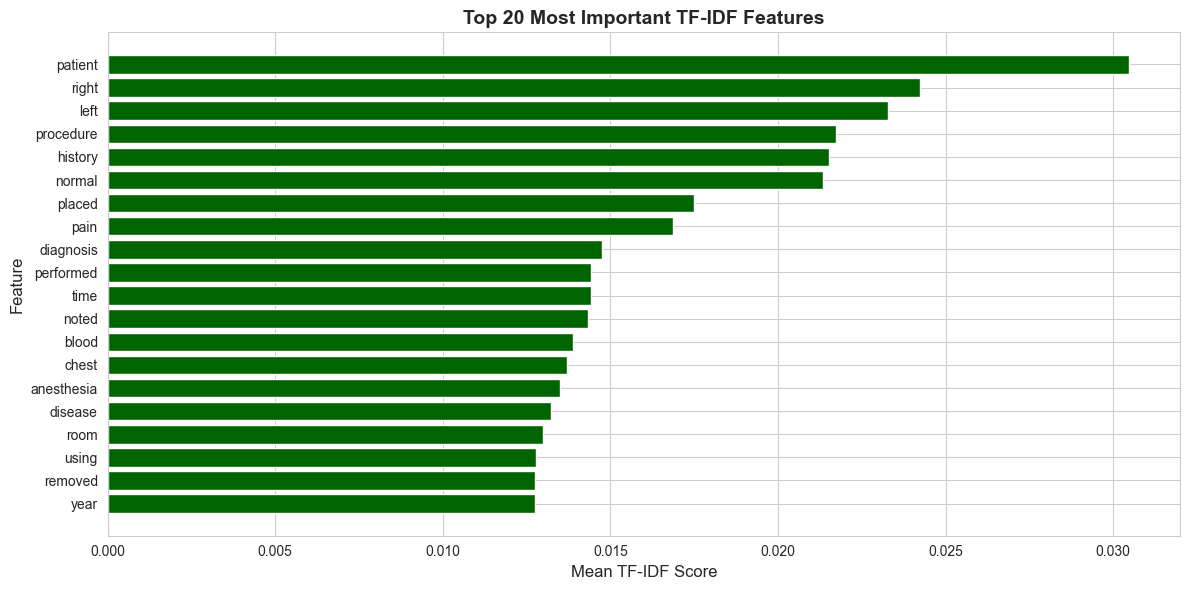

In [17]:
# Visualize top features
fig, ax = plt.subplots(figsize=(12, 6))
top_feature_names = [feature_names[idx] for idx in top_features_idx]
top_feature_scores = [mean_tfidf[idx] for idx in top_features_idx]

ax.barh(top_feature_names, top_feature_scores, color='darkgreen')
ax.set_xlabel('Mean TF-IDF Score', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Top 20 Most Important TF-IDF Features', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 10. Saving Preprocessed Data and Vectorizer

Saving the TF-IDF vectorizer and transformed data for use in subsequent notebooks.

In [18]:
import joblib
import os

# Create artifacts directory if it doesn't exist
os.makedirs('../artifacts', exist_ok=True)

# Save the fitted TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, '../artifacts/tfidf_vectorizer.joblib')
print("TF-IDF vectorizer saved to ../artifacts/tfidf_vectorizer.joblib")

# Save the transformed data
joblib.dump(X_train_tfidf, '../artifacts/X_train_tfidf.joblib')
joblib.dump(X_val_tfidf, '../artifacts/X_val_tfidf.joblib')
joblib.dump(X_test_tfidf, '../artifacts/X_test_tfidf.joblib')

joblib.dump(y_train, '../artifacts/y_train.joblib')
joblib.dump(y_val, '../artifacts/y_val.joblib')
joblib.dump(y_test, '../artifacts/y_test.joblib')

print("Transformed data saved successfully!")
print("\nAll preprocessing artifacts are ready for model training.")

TF-IDF vectorizer saved to ../artifacts/tfidf_vectorizer.joblib
Transformed data saved successfully!

All preprocessing artifacts are ready for model training.
